# Semi_defect_finder
반도체 공정/계측 데이터 기반 **결함 여부(불량/정상)** 이진 분류 모델 구축 노트북

- EDA → 전처리 → AutoML 모델링(A/B) → 평가 → 해석 → 운영(저장/스키마/드리프트)
- **시나리오 A**: `Etch_Depth` 포함(사후 판정 성격 가능)
- **시나리오 B**: `Etch_Depth` 제외(공정 조건+장비 상태 기반 사전/중간 판정)

> 요구사항에 따라 `Process_ID`, `Timestamp`는 **피처에서 제거**합니다(분할에만 필요하면 time-aware 옵션으로 사용).

## 필수 확인 질문 5개 (답 없이도 실행 가능)
1. 실제 타깃 컬럼명은? (`Defect` / `defect_flag` / `Join_Status` 등)
2. 운영 시점에 `Etch_Depth`를 결함 판정 전에 확보 가능한가?
3. 그룹 누수 방지를 위한 키 존재 여부? (우선 `lot_id`, 없으면 `wafer_id`/`Wafer_ID`)
4. 데이터가 단일 공정인지, `Tool_Type` 등 여러 공정 혼합인지?
5. 라벨(1)의 정의가 공정 결함인지(Defect), 최종 판정인지(Join_Status) — 중복/누수 점검 필요

---

In [1]:
# =========================================
# 0) CONFIG (여기만 바꿔 끼우면 됩니다)
# =========================================
CONFIG = {
    # 데이터
    "csv_path": "data/semiconductor_quality_control.csv",

    # 타깃 후보 (우선순위대로 탐색)
    "target_candidates": ["defect_flag", "Defect", "defect", "DEFECT"],

    # Join_Status를 타깃으로 쓰고 싶다면 True로 (Defect와 중복/누수 확인 로직 포함)
    "use_join_status_as_target": False,
    "join_status_col_candidates": ["Join_Status", "join_status"],
    "join_status_positive_values": ["Non-Joining", "FAIL", "Fail", "NG", "Bad", "Defect", "1"],  # 필요시 수정

    # 누수 위험 컬럼/ID류/시간류 (피처에서 제거)
    "drop_cols_always": ["Process_ID", "process_id", "Timestamp", "timestamp"],

    # Etch_Depth 후보 (A/B 시나리오 분기)
    "etch_depth_candidates": ["Etch_Depth", "etch_depth"],

    # 그룹 분할 우선순위: lot_id -> wafer_id -> Wafer_ID
    "group_candidates": ["lot_id", "Lot_ID", "wafer_id", "Wafer_ID", "die_id", "Die_ID"],

    # 시간 분할 컬럼 후보 (분할에만 사용)
    "time_candidates": ["timestamp", "Timestamp", "time", "Time", "datetime", "DateTime"],

    # 모델/검증
    "random_state": 42,
    "test_size": 0.2,
    "cv_splits": 5,
    "n_iter_search": 30,
    "scoring_primary": "average_precision",  # PR-AUC(AP)
    "precision_constraint": 0.90,            # threshold 선택 시 precision 최소
    "calibration": None,                     # None / "sigmoid" / "isotonic"

    # 전처리 옵션
    "use_iterative_imputer": False,          # True로 바꾸면 IterativeImputer 사용
    "winsorize_limits": (0.01, 0.01),        # 상하 1% winsorization
    "use_isolation_forest": False,           # 선택 옵션(훈련셋 필터링 원칙)

    # 출력/저장
    "model_output_dir": "./artifacts",
    "model_name_prefix": "semi_defect_model",
}

In [6]:
# =========================================
# 1) Imports & Utilities
# =========================================
import os, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import List, Optional

from sklearn.model_selection import StratifiedKFold, GroupKFold, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (
    average_precision_score, precision_recall_curve, roc_auc_score,
    f1_score, precision_score, recall_score, confusion_matrix,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, TransformerMixin

import joblib

In [7]:
# =========================================
# 2) Custom Transformers (winsorization) & helpers
# =========================================
class Winsorizer(BaseEstimator, TransformerMixin):
    """훈련 데이터 quantile로 상/하 클리핑."""
    def __init__(self, lower=0.01, upper=0.01):
        self.lower = lower
        self.upper = upper
        self.q_low_ = None
        self.q_high_ = None

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        self.q_low_ = X.quantile(self.lower)
        self.q_high_ = X.quantile(1 - self.upper)
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        return X.clip(self.q_low_, self.q_high_, axis=1).values


@dataclass
class SchemaInfo:
    expected_columns: List[str]
    numeric_columns: List[str]
    categorical_columns: List[str]


def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)


def find_first_existing(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    for c in candidates:
        if c in df.columns:
            return c
    return None

In [ ]:
# =========================================
# 3) Load data & resolve target/group/time/etch
# =========================================
df = pd.read_csv(CONFIG("csv_path"))
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# --- target column 결정
if CONFIG["use_join_status_as_target"]:
    js_col = find_first_existing(df, CONFIG["join_status_col_candidates"])
    if js_col is None:
        raise ValueError("use_join_status_as_target=True인데 Join_Status 컬럼을 찾지 못했습니다. CONFIG 수정 필요.")
    target_col = js_col
    pos_set = set([str(x) for x in CONFIG["join_status_positive_values"]])
    y = df[target_col].astype(str).isin(pos_set).astype(int)
else:
    target_col = find_first_existing(df, CONFIG["target_candidates"])
    if target_col is None:
        raise ValueError(f"타깃 컬럼을 찾지 못했습니다. candidates={CONFIG['target_candidates']} 확인 필요.")
    y = df[target_col].astype(int)

print(f"Target col resolved: {target_col}, positive rate={y.mean():.4f}")

# --- Etch_Depth 컬럼(있으면 A/B 분기에 사용)
etch_col = find_first_existing(df, CONFIG["etch_depth_candidates"])
print("Etch_Depth resolved:", etch_col)

# --- group key 결정
group_col = find_first_existing(df, CONFIG["group_candidates"])
groups = df[group_col].astype(str) if group_col else None
print("Group key resolved:", group_col if group_col else "None (누수 위험 경고)")

# --- time column 결정(분할에만 사용)
time_col = find_first_existing(df, CONFIG["time_candidates"])
if time_col:
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
print("Time col resolved:", time_col if time_col else "None")

Shape: (4219, 16)
Columns: ['Process_ID', 'Timestamp', 'Tool_Type', 'Wafer_ID', 'Chamber_Temperature', 'Gas_Flow_Rate', 'RF_Power', 'Etch_Depth', 'Rotation_Speed', 'Vacuum_Pressure', 'Stage_Alignment_Error', 'Vibration_Level', 'UV_Exposure_Intensity', 'Particle_Count', 'Defect', 'Join_Status']
Target col resolved: Defect, positive rate=0.1462
Etch_Depth resolved: Etch_Depth
Group key resolved: Wafer_ID
Time col resolved: Timestamp


## EDA
- 결측 비율
- 타깃 비율(불량률)
- 분포/이상치 후보(IQR)
- 상관/다중공선성 힌트(상관 상위 페어)
- Tail 분석(Particle/Vibration/Alignment)

> heatmap 대신 상관 상위 pair 요약으로 경량화했습니다.

In [9]:
# =========================================
# 4) EDA helpers
# =========================================
def basic_eda(dfX: pd.DataFrame, y: pd.Series, max_unique_for_cat=30):
    eda = {}
    eda["na_ratio"] = dfX.isna().mean().sort_values(ascending=False)
    eda["target_rate"] = float(y.mean())

    cat_cols, num_cols = [], []
    for c in dfX.columns:
        if pd.api.types.is_numeric_dtype(dfX[c]):
            num_cols.append(c)
        else:
            if dfX[c].nunique(dropna=True) <= max_unique_for_cat:
                cat_cols.append(c)

    eda["num_cols"] = num_cols
    eda["cat_cols"] = cat_cols

    outlier_counts = {}
    for c in num_cols:
        s = dfX[c].dropna()
        if len(s) < 10:
            continue
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
        outlier_counts[c] = int(((dfX[c] < lo) | (dfX[c] > hi)).sum())
    eda["iqr_outlier_counts"] = pd.Series(outlier_counts).sort_values(ascending=False)
    return eda


def plot_target_rate(y: pd.Series):
    rate = y.mean()
    plt.figure()
    plt.bar(["Normal(0)", "Defect(1)"], [1-rate, rate])
    plt.title(f"Target rate (defect=1): {rate:.4f}")
    plt.show()


def plot_numeric_distributions(dfX: pd.DataFrame, cols, ncols=3, bins=40, max_plots=12):
    cols = list(cols)[:max_plots]
    if not cols:
        print("No numeric columns to plot.")
        return
    n = len(cols)
    nrows = int(np.ceil(n / ncols))
    plt.figure(figsize=(5*ncols, 3*nrows))
    for i, c in enumerate(cols, 1):
        plt.subplot(nrows, ncols, i)
        s = dfX[c].dropna()
        plt.hist(s, bins=bins)
        plt.title(c)
    plt.tight_layout()
    plt.show()


def plot_tail(dfX: pd.DataFrame, col: str, top_q=0.99):
    if col not in dfX.columns or not pd.api.types.is_numeric_dtype(dfX[col]):
        print(f"Skip tail plot: {col} not found or not numeric")
        return
    s = dfX[col].dropna()
    if len(s) < 20:
        print(f"Skip tail plot: {col} too few samples")
        return
    thr = s.quantile(top_q)
    tail = s[s >= thr]
    plt.figure()
    plt.hist(tail, bins=30)
    plt.title(f"{col} tail >= q{top_q} (thr={thr:.4g}), count={len(tail)}")
    plt.show()


def corr_hint(dfX: pd.DataFrame, num_cols, topk=20):
    if len(num_cols) < 2:
        print("Not enough numeric columns for correlation.")
        return
    c = dfX[num_cols].corr()
    pairs = []
    for i in range(len(num_cols)):
        for j in range(i+1, len(num_cols)):
            a, b = num_cols[i], num_cols[j]
            val = c.loc[a, b]
            if pd.isna(val):
                continue
            pairs.append((a, b, float(val), float(abs(val))))
    pairs = sorted(pairs, key=lambda x: x[3], reverse=True)[:topk]
    out = pd.DataFrame(pairs, columns=["feat_a", "feat_b", "corr", "abs_corr"])
    print("Top correlated pairs (multicollinearity hint):")
    display(out)

[주의] Join_Status는 누수 가능성이 있어 피처에서 제거합니다.
Target defect rate: 0.14624318558900212

Missing ratio (top 20):


Tool_Type                0.0
Wafer_ID                 0.0
Chamber_Temperature      0.0
Gas_Flow_Rate            0.0
RF_Power                 0.0
Etch_Depth               0.0
Rotation_Speed           0.0
Vacuum_Pressure          0.0
Stage_Alignment_Error    0.0
Vibration_Level          0.0
UV_Exposure_Intensity    0.0
Particle_Count           0.0
dtype: float64


IQR outlier candidate counts (top 20):


Chamber_Temperature      35
Etch_Depth               34
Rotation_Speed           31
Vibration_Level          29
Vacuum_Pressure          25
UV_Exposure_Intensity    25
RF_Power                 22
Stage_Alignment_Error    20
Gas_Flow_Rate            19
Particle_Count            0
dtype: int64

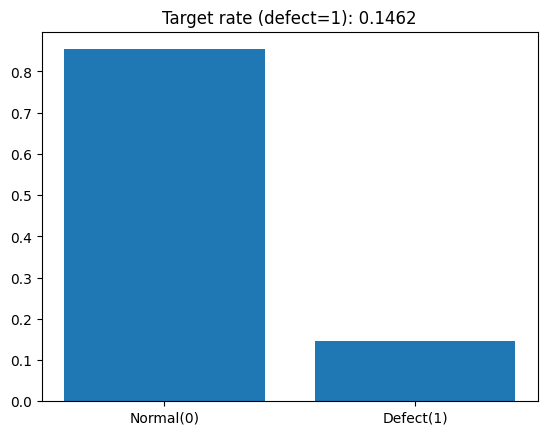

Numeric cols: ['Chamber_Temperature', 'Gas_Flow_Rate', 'RF_Power', 'Etch_Depth', 'Rotation_Speed', 'Vacuum_Pressure', 'Stage_Alignment_Error', 'Vibration_Level', 'UV_Exposure_Intensity', 'Particle_Count']
Categorical cols: ['Tool_Type']


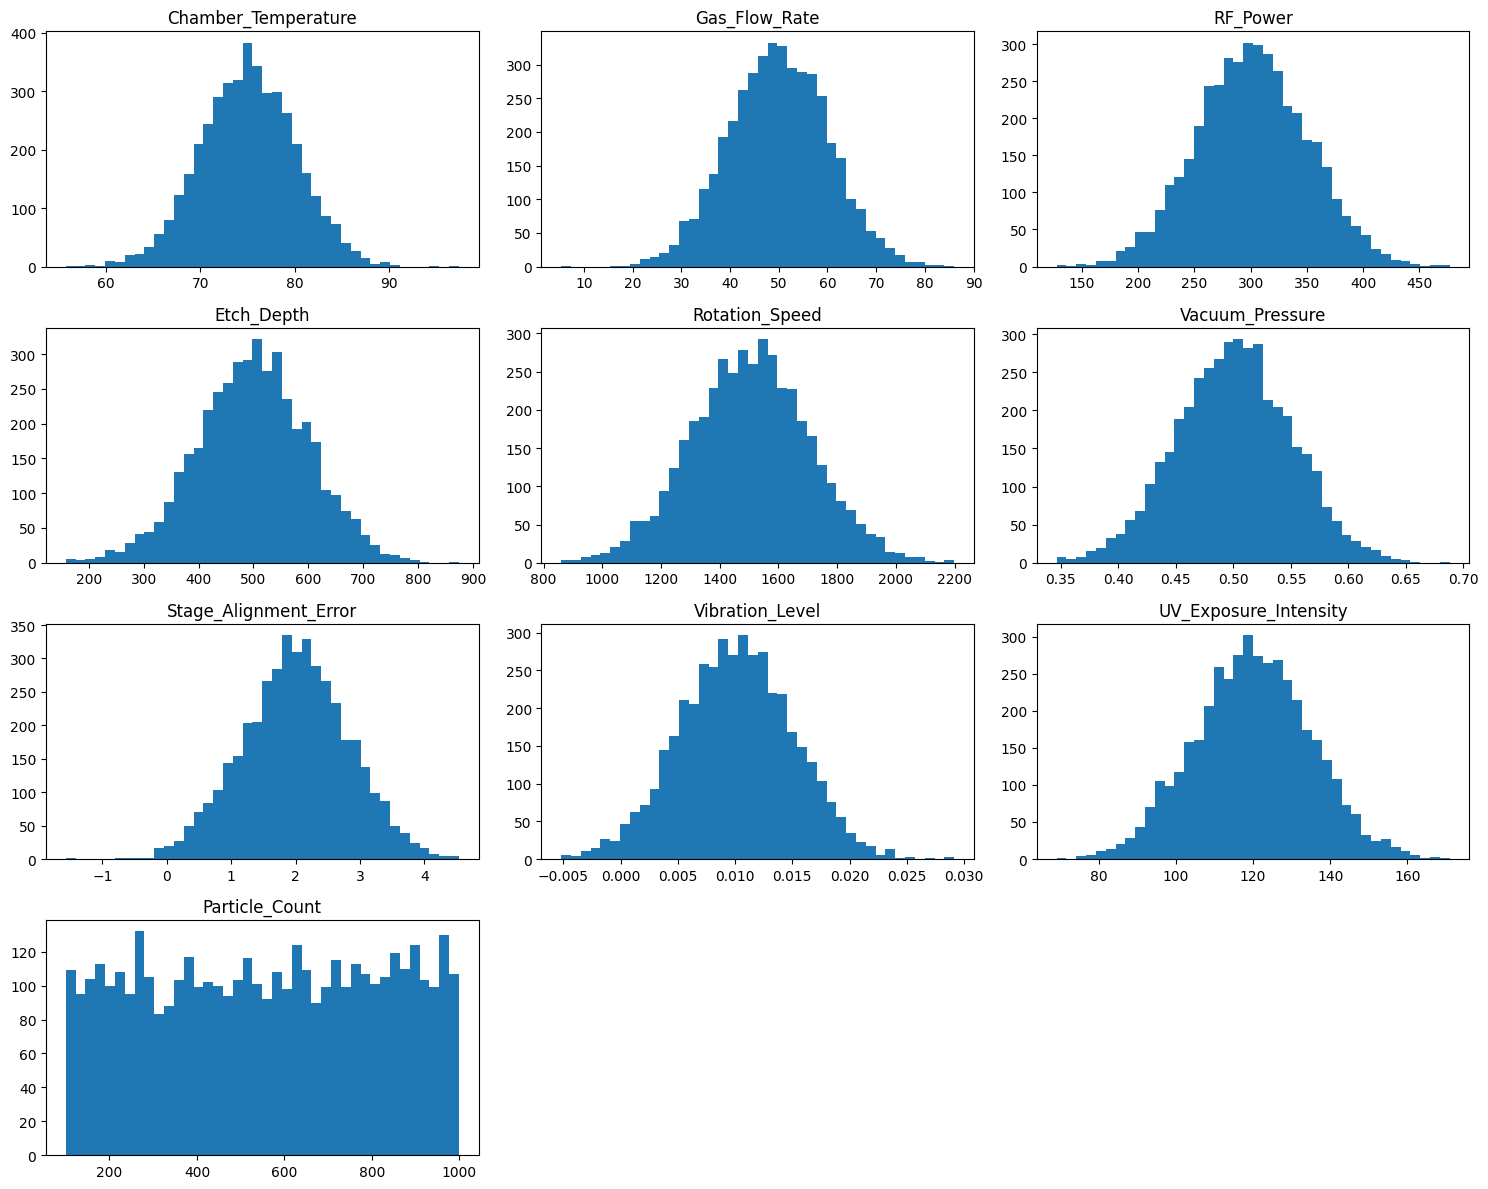

Top correlated pairs (multicollinearity hint):


,feat_a,feat_b,corr,abs_corr
0,Vacuum_Pressure,Stage_Alignment_Error,-0.038484,0.038484
1,RF_Power,Vacuum_Pressure,0.033769,0.033769
2,RF_Power,Etch_Depth,0.025995,0.025995
3,Stage_Alignment_Error,UV_Exposure_Intensity,-0.025627,0.025627
4,Stage_Alignment_Error,Particle_Count,-0.021193,0.021193
5,Gas_Flow_Rate,Rotation_Speed,0.019115,0.019115
6,Gas_Flow_Rate,RF_Power,0.017711,0.017711
7,Etch_Depth,Vibration_Level,-0.017555,0.017555
8,Gas_Flow_Rate,Stage_Alignment_Error,0.016518,0.016518
9,Rotation_Speed,Vacuum_Pressure,-0.016377,0.016377


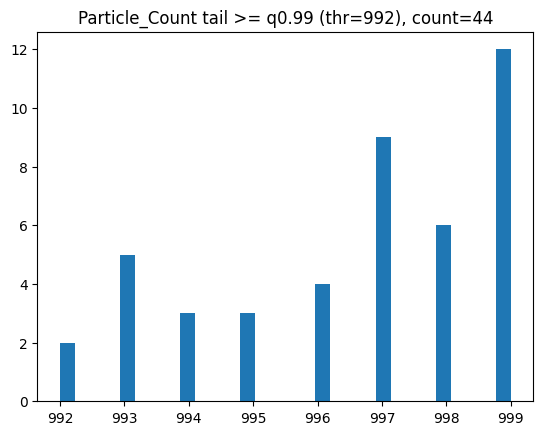

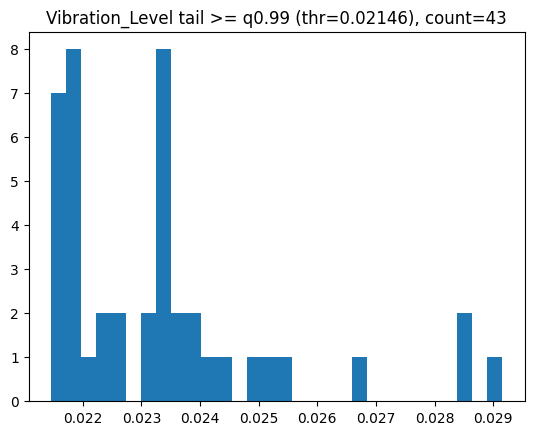

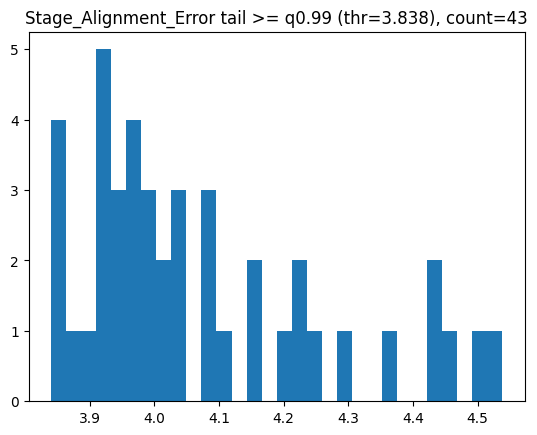

In [10]:
# =========================================
# 5) Run EDA
# =========================================
X_raw = df.drop(columns=[target_col], errors="ignore").copy()
X_raw = X_raw.drop(columns=[c for c in CONFIG["drop_cols_always"] if c in X_raw.columns], errors="ignore")

# Join_Status는 피처로 넣지 않는 것이 안전(누수 가능)
for c in CONFIG["join_status_col_candidates"]:
    if c in X_raw.columns and c != target_col:
        print(f"[주의] {c}는 누수 가능성이 있어 피처에서 제거합니다.")
        X_raw = X_raw.drop(columns=[c], errors="ignore")

eda = basic_eda(X_raw, y)

print("Target defect rate:", eda["target_rate"])
print("\nMissing ratio (top 20):")
display(eda["na_ratio"].head(20))

print("\nIQR outlier candidate counts (top 20):")
display(eda["iqr_outlier_counts"].head(20))

plot_target_rate(y)

print("Numeric cols:", eda["num_cols"])
print("Categorical cols:", eda["cat_cols"])

plot_numeric_distributions(X_raw, eda["num_cols"], max_plots=12)
corr_hint(X_raw, eda["num_cols"], topk=20)

for col in ["Particle_Count", "Vibration_Level", "Stage_Alignment_Error"]:
    plot_tail(X_raw, col, top_q=0.99)

## 누수 점검: `Defect` vs `Join_Status`
두 라벨이 거의 동일하면(예: 0.98 이상 일치) 서로를 섞어 쓰는 순간 누수 가능성이 큽니다.

In [11]:
# =========================================
# 6) Leakage check: Defect vs Join_Status (if both exist)
# =========================================
js_col = find_first_existing(df, CONFIG["join_status_col_candidates"])
if js_col and (target_col != js_col) and (target_col in df.columns):
    pos_set = set([str(x) for x in CONFIG["join_status_positive_values"]])
    js_bin = df[js_col].astype(str).isin(pos_set).astype(int)
    agree = (js_bin.values == y.values).mean()
    print(f"[Leakage check] Agreement between {target_col} and {js_col}: {agree:.4f}")
    if agree > 0.98:
        print("[경고] 두 라벨이 거의 동일합니다. Join_Status를 피처로 사용하거나 목표로 섞으면 누수 가능성이 큽니다.")
else:
    print("Join_Status leakage check skipped (missing or same as target).")

[Leakage check] Agreement between Defect and Join_Status: 1.0000
[경고] 두 라벨이 거의 동일합니다. Join_Status를 피처로 사용하거나 목표로 섞으면 누수 가능성이 큽니다.


## 전처리 & AutoML 모델링
- 결측: `SimpleImputer(median)` 기본 (옵션: `IterativeImputer`)
- 이상치 대응: winsorization(상하 1% 기본)
- 스케일링: `RobustScaler`
- AutoML: 후보 모델(LogReg/RF/HGB/SVC) + `RandomizedSearchCV`
- 검증: 그룹 키 있으면 `GroupKFold`, 없으면 StratifiedKFold(누수 위험 경고)

### 시나리오
- **A**: Etch_Depth 포함
- **B**: Etch_Depth 제외

In [21]:
# =========================================
# 7) Preprocess + AutoML
# =========================================
def build_preprocess(dfX: pd.DataFrame, use_iterative=False, winsor_limits=(0.01, 0.01)):
    num_cols = [c for c in dfX.columns if pd.api.types.is_numeric_dtype(dfX[c])]
    cat_cols = [c for c in dfX.columns if c not in num_cols]

    num_imputer = (IterativeImputer(random_state=CONFIG["random_state"], max_iter=15)
                   if use_iterative else SimpleImputer(strategy="median"))

    num_pipe = Pipeline(steps=[
        ("imputer", num_imputer),
        ("winsor", Winsorizer(lower=winsor_limits[0], upper=winsor_limits[1])),
        ("scaler", RobustScaler(with_centering=True)),
    ])

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ])

    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=True
    )

    schema = SchemaInfo(
        expected_columns=list(dfX.columns),
        numeric_columns=num_cols,
        categorical_columns=cat_cols
    )
    return pre, schema


def get_model_search_space(random_state=42):
    models = []

    lr = LogisticRegression(max_iter=3000, class_weight="balanced", solver="liblinear")
    lr_space = {"clf__C": np.logspace(-3, 2, 50), "clf__penalty": ["l1", "l2"]}
    models.append(("LogReg", lr, lr_space))

    rf = RandomForestClassifier(
        n_estimators=400, random_state=random_state,
        class_weight="balanced_subsample", n_jobs=-1
    )
    rf_space = {
        "clf__max_depth": [None, 4, 6, 8, 12, 16],
        "clf__min_samples_leaf": [1, 2, 5, 10],
        "clf__min_samples_split": [2, 5, 10, 20],
        "clf__max_features": ["sqrt", "log2", 0.5, 0.8],
    }
    models.append(("RF", rf, rf_space))

    hgb = HistGradientBoostingClassifier(
        random_state=random_state, class_weight="balanced", early_stopping=True
    )
    hgb_space = {
        "clf__learning_rate": np.linspace(0.02, 0.2, 20),
        "clf__max_depth": [None, 3, 5, 7, 9],
        "clf__max_leaf_nodes": [15, 31, 63, 127],
        "clf__min_samples_leaf": [10, 20, 50, 100],
        "clf__l2_regularization": np.logspace(-6, -2, 20),
    }
    models.append(("HGB", hgb, hgb_space))

    svc = SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=random_state)
    svc_space = {"clf__C": np.logspace(-2, 2, 30), "clf__gamma": ["scale", "auto"]}
    models.append(("SVC", svc, svc_space))

    return models


def get_cv_splitter(y, groups=None, time_series=False, n_splits=5):
    if time_series:
        return TimeSeriesSplit(n_splits=n_splits)
    if groups is not None:
        return GroupKFold(n_splits=n_splits)
    print("[경고] 그룹 키가 없어서 StratifiedKFold 사용. 수집 단위 섞임(누수) 가능성을 리포트에 명시하세요.")
    return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=CONFIG["random_state"])


def run_automl(dfX: pd.DataFrame, y: pd.Series, groups=None, time_series=False, label="Model"):
    pre, schema = build_preprocess(
        dfX,
        use_iterative=CONFIG["use_iterative_imputer"],
        winsor_limits=CONFIG["winsorize_limits"]
    )
    splitter = get_cv_splitter(y, groups=groups, time_series=time_series, n_splits=CONFIG["cv_splits"])

    results = []
    best = None

    for name, clf, space in get_model_search_space(CONFIG["random_state"]):
        pipe = Pipeline(steps=[("pre", pre), ("clf", clf)])
        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=space,
            n_iter=CONFIG["n_iter_search"],
            scoring=CONFIG["scoring_primary"],
            cv=splitter,
            refit=True,
            random_state=CONFIG["random_state"],
            n_jobs=-1,
            verbose=0,
        )
        if isinstance(splitter, GroupKFold):
            search.fit(dfX, y, groups=groups)
        else:
            search.fit(dfX, y)

        best_score = search.best_score_
        results.append((label, name, best_score, search.best_params_))
        print(f"[{label}] {name} best CV AP={best_score:.4f}")

        if (best is None) or (best_score > best["best_score"]):
            best = {
                "label": label,
                "model_name": name,
                "best_score": best_score,
                "estimator": search.best_estimator_,
                "schema": schema,
                "best_params": search.best_params_,
            }

    res_df = pd.DataFrame(results, columns=["scenario", "model", "cv_AP", "best_params"]).sort_values("cv_AP", ascending=False)
    return best, res_df

In [13]:
# =========================================
# 8) Prepare scenario A/B feature sets
# =========================================
baseX = df.drop(columns=[target_col], errors="ignore").copy()
baseX = baseX.drop(columns=[c for c in CONFIG["drop_cols_always"] if c in baseX.columns], errors="ignore")

# Join_Status는 피처로 제거(누수 방지)
for c in CONFIG["join_status_col_candidates"]:
    if c in baseX.columns and c != target_col:
        baseX = baseX.drop(columns=[c], errors="ignore")

XA = baseX.copy()   # A: Etch_Depth 포함
XB = baseX.copy()   # B: Etch_Depth 제외
if etch_col and etch_col in XB.columns:
    XB = XB.drop(columns=[etch_col], errors="ignore")

print("Scenario A cols:", XA.shape[1], "| Scenario B cols:", XB.shape[1])

# time-aware split은 선택 옵션(기본 False)
time_series = False

Scenario A cols: 12 | Scenario B cols: 11


In [14]:
# =========================================
# 9) Run AutoML for A/B
# =========================================
bestA, tableA = run_automl(XA, y, groups=groups if group_col else None, time_series=time_series, label="A_with_EtchDepth")
bestB, tableB = run_automl(XB, y, groups=groups if group_col else None, time_series=time_series, label="B_without_EtchDepth")

print("\n=== Leaderboard A ===")
display(tableA.head(10))
print("\n=== Leaderboard B ===")
display(tableB.head(10))

print("\nBest A:", bestA["model_name"], bestA["best_score"])
print("Best B:", bestB["model_name"], bestB["best_score"])

[A_with_EtchDepth] LogReg best CV AP=0.1517
[A_with_EtchDepth] RF best CV AP=0.1622
[A_with_EtchDepth] HGB best CV AP=0.1627
[A_with_EtchDepth] SVC best CV AP=0.1514
[B_without_EtchDepth] LogReg best CV AP=0.1506
[B_without_EtchDepth] RF best CV AP=0.1628
[B_without_EtchDepth] HGB best CV AP=0.1642
[B_without_EtchDepth] SVC best CV AP=0.1592

=== Leaderboard A ===


,scenario,model,cv_AP,best_params
2,A_with_EtchDepth,HGB,0.162747,"{'clf__min_samples_leaf': 50, 'clf__max_leaf_n..."
1,A_with_EtchDepth,RF,0.162173,"{'clf__min_samples_split': 20, 'clf__min_sampl..."
0,A_with_EtchDepth,LogReg,0.151671,"{'clf__penalty': 'l1', 'clf__C': 79.0604321090..."
3,A_with_EtchDepth,SVC,0.151373,"{'clf__gamma': 'scale', 'clf__C': 1.1721022975..."



=== Leaderboard B ===


,scenario,model,cv_AP,best_params
2,B_without_EtchDepth,HGB,0.164189,"{'clf__min_samples_leaf': 10, 'clf__max_leaf_n..."
1,B_without_EtchDepth,RF,0.162801,"{'clf__min_samples_split': 10, 'clf__min_sampl..."
3,B_without_EtchDepth,SVC,0.159155,"{'clf__gamma': 'scale', 'clf__C': 1.1721022975..."
0,B_without_EtchDepth,LogReg,0.150592,"{'clf__penalty': 'l1', 'clf__C': 79.0604321090..."



Best A: HGB 0.16274707149126572
Best B: HGB 0.16418869699877195


## 평가/검증
- 지표: **PR-AUC(AP)** 우선, ROC-AUC 참고, F1
- 운영 기준: **Precision ≥ 0.90** 제약 하에서 Recall 최대화 threshold 선택
- PR curve, confusion matrix, ROC curve(참고), calibration curve

In [18]:
# =========================================
# 10) Hold-out split + threshold selection + plots
# =========================================
def group_holdout_split(dfX, y, groups, test_size=0.2, random_state=42):
    rng = np.random.RandomState(random_state)
    uniq = pd.Series(groups).unique()
    rng.shuffle(uniq)
    n_test = int(np.ceil(len(uniq) * test_size))
    test_groups = set(uniq[:n_test])

    is_test = pd.Series(groups).isin(test_groups).values
    X_train, X_test = dfX.loc[~is_test], dfX.loc[is_test]
    y_train, y_test = y.loc[~is_test], y.loc[is_test]
    return X_train, X_test, y_train, y_test


def find_best_threshold_precision_constraint(y_true, y_prob, min_precision=0.90):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    best = {"threshold": 0.5, "precision": 0.0, "recall": 0.0}
    for p, r, thr in zip(precisions[1:], recalls[1:], thresholds):
        if p >= min_precision and r > best["recall"]:
            best = {"threshold": float(thr), "precision": float(p), "recall": float(r)}
    feasible = best["precision"] >= min_precision
    return feasible, best


def eval_binary(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    ap = average_precision_score(y_true, y_prob)
    roc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) == 2 else np.nan
    f1 = f1_score(y_true, y_pred, zero_division=0)
    p = precision_score(y_true, y_pred, zero_division=0)
    r = recall_score(y_true, y_pred, zero_division=0)
    return {"AP": ap, "ROC_AUC": roc, "F1": f1, "Precision": p, "Recall": r}


def plot_pr_curve(y_true, y_prob, title="PR Curve"):
    PrecisionRecallDisplay.from_predictions(y_true, y_prob)
    plt.title(title)
    plt.show()


def plot_confusion(y_true, y_prob, thr, title="Confusion Matrix"):
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(values_format="d")
    plt.title(f"{title} (thr={thr:.3f})")
    plt.show()


def plot_calibration(y_true, y_prob, title="Calibration"):
    frac_pos, mean_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy="quantile")
    plt.figure()
    plt.plot(mean_pred, frac_pos, marker="o")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(title)
    plt.show()


def evaluate_best(best_pack, dfX, y, groups=None, scenario_name="Scenario"):
    est = best_pack["estimator"]

    if groups is not None:
        X_train, X_test, y_train, y_test = group_holdout_split(
            dfX, y, groups,
            test_size=CONFIG["test_size"],
            random_state=CONFIG["random_state"]
        )
        split_type = "group_holdout"
    else:
        print("[경고] 그룹 holdout 불가 -> 랜덤 holdout은 누수 가능성이 있습니다.")
        idx = np.arange(len(dfX))
        rng = np.random.RandomState(CONFIG["random_state"])
        rng.shuffle(idx)
        n_test = int(np.ceil(len(idx)*CONFIG["test_size"]))
        test_idx = idx[:n_test]
        train_idx = idx[n_test:]
        X_train, X_test = dfX.iloc[train_idx], dfX.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        split_type = "random_holdout"

    est.fit(X_train, y_train)

    if CONFIG["calibration"] in ["sigmoid", "isotonic"]:
        cal = CalibratedClassifierCV(estimator=est, method=CONFIG["calibration"], cv=3)
        cal.fit(X_train, y_train)
        model = cal
    else:
        model = est

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        scores = model.decision_function(X_test)
        y_prob = 1 / (1 + np.exp(-scores))

    feasible, best_thr = find_best_threshold_precision_constraint(
        y_test.values, y_prob, CONFIG["precision_constraint"]
    )
    thr = best_thr["threshold"] if feasible else 0.5
    metrics = eval_binary(y_test.values, y_prob, thr=thr)

    print(f"\n[{scenario_name}] split={split_type}")
    print("Best threshold under precision constraint:", best_thr)
    print("Metrics:", metrics)

    plot_pr_curve(y_test.values, y_prob, title=f"{scenario_name} PR Curve (AP={metrics['AP']:.4f})")
    plot_confusion(y_test.values, y_prob, thr, title=f"{scenario_name} Confusion Matrix")

    try:
        RocCurveDisplay.from_predictions(y_test.values, y_prob)
        plt.title(f"{scenario_name} ROC Curve (ROC-AUC={metrics['ROC_AUC']:.4f})")
        plt.show()
    except Exception:
        pass

    plot_calibration(y_test.values, y_prob, title=f"{scenario_name} Calibration")

    return {
        "model": model,
        "estimator_unrefit": est,
        "threshold": thr,
        "metrics": metrics,
        "best_thr_detail": best_thr,
        "split_type": split_type,
        "X_train": X_train, "y_train": y_train,
        "X_test": X_test, "y_test": y_test,
        "y_prob": y_prob
    }


[A_with_EtchDepth] split=group_holdout
Best threshold under precision constraint: {'threshold': 0.5, 'precision': 0.0, 'recall': 0.0}
Metrics: {'AP': 0.14600278790722976, 'ROC_AUC': 0.49971303948576673, 'F1': 0.20603015075376885, 'Precision': 0.1474820143884892, 'Recall': 0.3416666666666667}


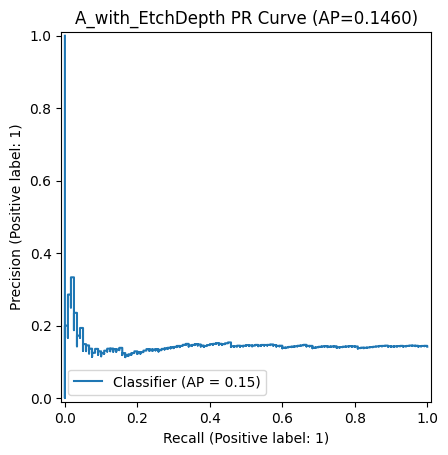

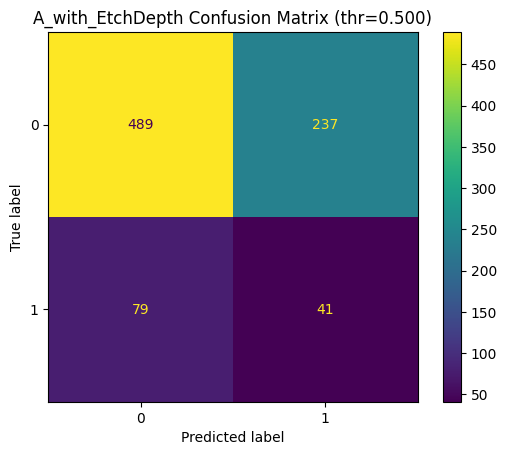

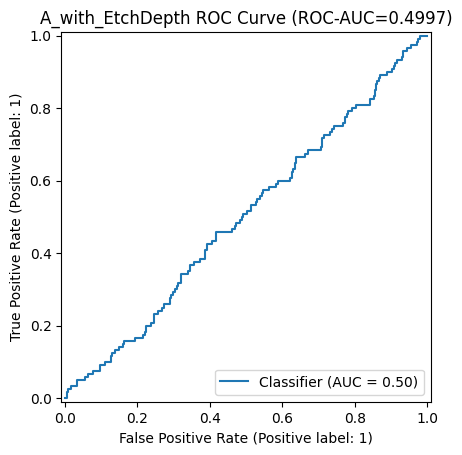

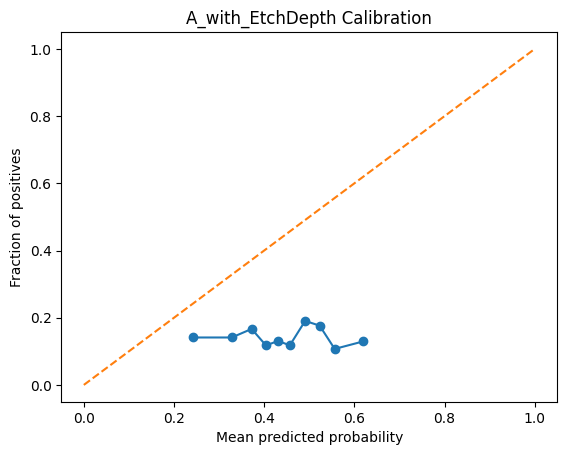


[B_without_EtchDepth] split=group_holdout
Best threshold under precision constraint: {'threshold': 0.5, 'precision': 0.0, 'recall': 0.0}
Metrics: {'AP': 0.15426569135674886, 'ROC_AUC': 0.5099230945821855, 'F1': 0.22055137844611528, 'Precision': 0.15770609318996415, 'Recall': 0.36666666666666664}


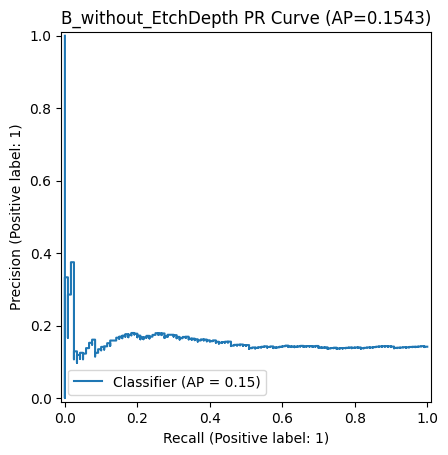

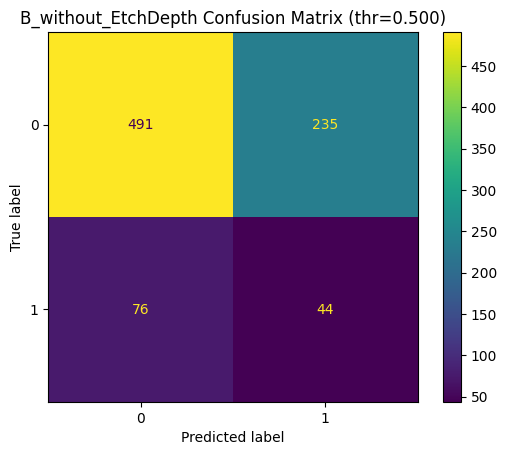

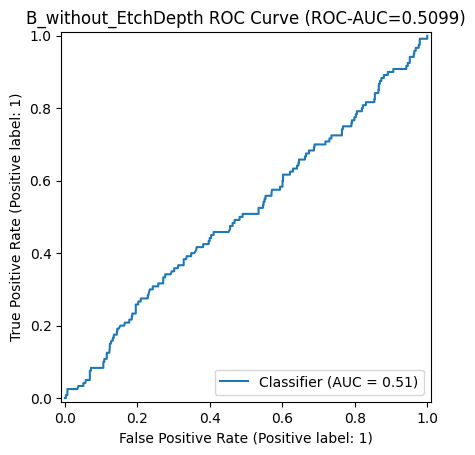

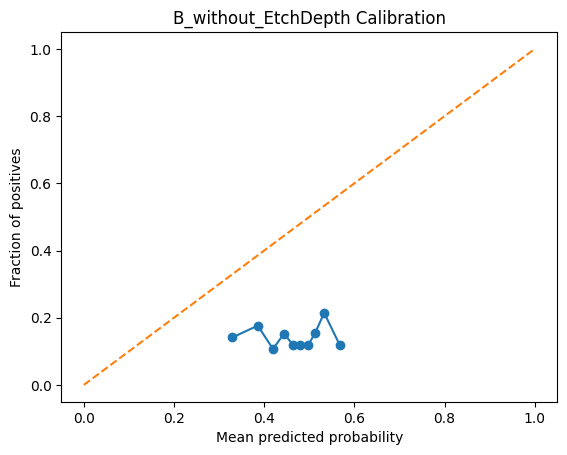

In [16]:
# =========================================
# 11) Evaluate A/B
# =========================================
resA = evaluate_best(bestA, XA, y, groups=groups if group_col else None, scenario_name="A_with_EtchDepth")
resB = evaluate_best(bestB, XB, y, groups=groups if group_col else None, scenario_name="B_without_EtchDepth")

## 해석
- 기본: permutation importance
- (옵션) SHAP: tree 기반에서 유용(환경에 따라 설치 필요)

### 물리 sanity check 가이드
- Vacuum_Pressure↑ → 플라즈마/가스/파티클 안정성 저하 가능
- Stage_Alignment_Error↑, Vibration_Level↑ → 정렬/overlay 불안정으로 결함 증가 가설
- Particle_Count tail(상위 1%)에서 불량률 급증 여부 확인(룰 기반 경보로도 유용)

In [22]:
# =========================================
# 12) Permutation importance
# =========================================
def get_feature_names_from_pipeline(pipe: Pipeline) -> List[str]:
    pre = pipe.named_steps.get("pre", None)
    if pre is None:
        return []
    try:
        return list(pre.get_feature_names_out())
    except Exception:
        return []

def perm_importance(model, X_test, y_test, n_repeats=10, topk=20, title="Permutation Importance"):
    r = permutation_importance(
        model, X_test, y_test,
        scoring=CONFIG["scoring_primary"],
        n_repeats=n_repeats,
        random_state=CONFIG["random_state"],
        n_jobs=-1
    )
    feats = get_feature_names_from_pipeline(model) if isinstance(model, Pipeline) else list(range(X_test.shape[1]))
    imp = pd.DataFrame({
        "feature": feats,
        "importance_mean": r.importances_mean,
        "importance_std": r.importances_std
    }).sort_values("importance_mean", ascending=False)

    display(imp.head(topk))

    plt.figure(figsize=(8, 5))
    plt.barh(imp.head(topk)["feature"][::-1], imp.head(topk)["importance_mean"][::-1])
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return imp

impA = perm_importance(resA["estimator_unrefit"], resA["X_test"], resA["y_test"], title="A Permutation Importance (AP)")
impB = perm_importance(resB["estimator_unrefit"], resB["X_test"], resB["y_test"], title="B Permutation Importance (AP)")

ValueError: All arrays must be of the same length

### SHAP 옵션(선택)
아래 코드는 환경에 따라 실행하세요.
```python
# pip install shap
import shap

# resB['estimator_unrefit'] 기준 예시 (파이프라인)
pipe = resB['estimator_unrefit']
pipe.fit(resB['X_train'], resB['y_train'])

pre = pipe.named_steps['pre']
clf = pipe.named_steps['clf']

X_train_tr = pre.transform(resB['X_train'])
X_test_tr  = pre.transform(resB['X_test'])

explainer = shap.Explainer(clf, X_train_tr)
shap_values = explainer(X_test_tr)
shap.plots.beeswarm(shap_values, max_display=20)
```

## 운영(저장/스키마 검증/추론/드리프트)
- `joblib`로 모델 저장
- 입력 컬럼 스키마 검증(누락/추가)
- 추론 함수: 확률 + threshold 판정
- 드리프트: PSI/KS (핵심 피처 우선 모니터링)

In [ ]:
# =========================================
# 13) Save artifacts
# =========================================
ensure_dir(CONFIG["model_output_dir"])

def save_artifacts(result_pack, scenario_tag: str, schema: SchemaInfo):
    model = result_pack["model"]
    thr = result_pack["threshold"]
    metrics = result_pack["metrics"]

    obj = {
        "scenario": scenario_tag,
        "threshold": thr,
        "metrics": metrics,
        "schema": schema.__dict__,
        "config": CONFIG,
    }

    model_path = os.path.join(CONFIG["model_output_dir"], f"{CONFIG['model_name_prefix']}_{scenario_tag}.joblib")
    meta_path  = os.path.join(CONFIG["model_output_dir"], f"{CONFIG['model_name_prefix']}_{scenario_tag}_meta.json")

    joblib.dump(model, model_path)
    with open(meta_path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

    print("Saved:", model_path)
    print("Saved:", meta_path)
    return model_path, meta_path

pathA, metaA = save_artifacts(resA, "A_with_EtchDepth", bestA["schema"])
pathB, metaB = save_artifacts(resB, "B_without_EtchDepth", bestB["schema"])

In [ ]:
# =========================================
# 14) Schema validation + inference
# =========================================
def validate_schema(input_df: pd.DataFrame, schema: SchemaInfo, strict=True):
    expected = set(schema.expected_columns)
    got = set(input_df.columns)

    missing = sorted(list(expected - got))
    extra = sorted(list(got - expected))

    ok = (len(missing) == 0) and (len(extra) == 0)

    if strict and not ok:
        raise ValueError(f"Schema mismatch. Missing={missing}, Extra={extra}")

    return {"ok": ok, "missing": missing, "extra": extra}


def predict_defect(model, input_df: pd.DataFrame, schema: SchemaInfo, threshold: float):
    chk = validate_schema(input_df, schema, strict=False)
    if chk["missing"]:
        raise ValueError(f"Input missing required columns: {chk['missing']}")
    if chk["extra"]:
        input_df = input_df[schema.expected_columns].copy()

    if hasattr(model, "predict_proba"):
        prob = model.predict_proba(input_df)[:, 1]
    else:
        scores = model.decision_function(input_df)
        prob = 1 / (1 + np.exp(-scores))

    pred = (prob >= threshold).astype(int)
    return pd.DataFrame({"defect_prob": prob, "defect_pred": pred})


loaded_model_B = joblib.load(pathB)
print(validate_schema(XB, bestB["schema"], strict=False))
display(predict_defect(loaded_model_B, XB.head(10), bestB["schema"], resB["threshold"]))

In [ ]:
# =========================================
# 15) Drift monitoring: PSI & KS
# =========================================
from scipy.stats import ks_2samp

def psi(expected: np.ndarray, actual: np.ndarray, bins=10, eps=1e-6):
    expected = expected[~np.isnan(expected)]
    actual = actual[~np.isnan(actual)]
    if len(expected) < 50 or len(actual) < 50:
        return np.nan

    quantiles = np.quantile(expected, np.linspace(0, 1, bins+1))
    quantiles[0] = -np.inf
    quantiles[-1] = np.inf

    e_counts, _ = np.histogram(expected, bins=quantiles)
    a_counts, _ = np.histogram(actual, bins=quantiles)

    e_perc = e_counts / (e_counts.sum() + eps)
    a_perc = a_counts / (a_counts.sum() + eps)

    e_perc = np.clip(e_perc, eps, 1)
    a_perc = np.clip(a_perc, eps, 1)

    return float(np.sum((a_perc - e_perc) * np.log(a_perc / e_perc)))


def drift_report(df_ref: pd.DataFrame, df_cur: pd.DataFrame, cols: List[str], bins=10):
    rows = []
    for c in cols:
        if c not in df_ref.columns or c not in df_cur.columns:
            continue
        if not pd.api.types.is_numeric_dtype(df_ref[c]):
            continue
        ref = df_ref[c].values
        cur = df_cur[c].values
        psi_val = psi(ref, cur, bins=bins)
        try:
            ks = ks_2samp(ref[~np.isnan(ref)], cur[~np.isnan(cur)])
            ks_stat, ks_p = float(ks.statistic), float(ks.pvalue)
        except Exception:
            ks_stat, ks_p = np.nan, np.nan
        rows.append((c, psi_val, ks_stat, ks_p))
    rep = pd.DataFrame(rows, columns=["feature", "PSI", "KS_stat", "KS_pvalue"]).sort_values("PSI", ascending=False)
    return rep

key_features = [c for c in ["Particle_Count","Vacuum_Pressure","Chamber_Temperature","Vibration_Level","Stage_Alignment_Error","RF_Power","Gas_Flow_Rate"] if c in XB.columns]
display(drift_report(resB["X_train"], resB["X_test"], key_features, bins=10))